In [1]:
import pandas as pd
import datetime as datetime
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [194]:
new_transactions = pd.read_csv('new_merchant_transactions.csv', parse_dates=['purchase_date'])
historical_transactions = pd.read_csv('historical_transactions.csv', parse_dates=['purchase_date'])


In [195]:
new_transactions = new_transactions.loc[new_transactions['purchase_amount']<0]
historical_transactions = historical_transactions.loc[historical_transactions['purchase_amount']<0]


In [196]:
def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

In [197]:
def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df
#_________________________________________
train = read_data('train.csv')
test = read_data('test.csv')

#target = train['target']
#del train['target']

In [198]:
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])

#historical_transactions = reduce_mem_usage(historical_transactions)
#new_transactions = reduce_mem_usage(new_transactions)

agg_fun = {'authorized_flag': ['sum', 'mean']}
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]

In [199]:
historical_transactions[:5]

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
115,0,C_ID_4e6213e9bc,88,0,0,842,M_ID_22c9cfa265,-10,-0.730379,2017-04-07 12:58:09,16,37,1,0,0,0,0,1,0,0
132,0,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-5,-0.723782,2017-09-17 22:40:27,16,16,1,0,0,0,0,1,0,0
148,0,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-5,-0.723782,2017-09-17 22:40:26,16,16,1,0,0,0,0,1,0,0
168,0,C_ID_4e6213e9bc,333,0,0,605,M_ID_c2ae34c2ef,0,-0.664262,2018-02-20 10:57:50,9,2,1,0,0,0,0,1,0,0
213,0,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-7,-0.738132,2017-07-08 07:33:31,16,34,1,0,0,0,0,1,0,0


In [200]:
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month

In [201]:
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_A': ['mean'],
        'category_3_B': ['mean'],
        'category_3_C': ['mean'],
        'merchant_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'city_id': ['nunique'],
        'subsector_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'min', 'max'],
        'month_lag': ['min', 'max']
        }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [202]:
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]

,card_id,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_min,hist_month_lag_max
0,C_ID_00007093c1,30,4,0.133333,0.000000,0.00,0.866667,0.0,0.000000,0.00,0.866667,0.133333,10,7,2,3,6,-16.533776,-0.551126,-0.145847,-0.728876,0.148713,36,1.20,3,1,0.550861,5.933333,12,1,3.289831,28858113.0,1.489250e+09,1.518108e+09,-11,0
1,C_ID_0001238066,3,0,0.000000,0.333333,0.00,0.000000,0.0,0.666667,0.00,1.000000,0.000000,2,1,2,2,1,-1.789928,-0.596643,-0.596643,-0.596643,0.000000,3,1.00,1,1,0.000000,8.666667,12,2,5.773503,3609150.0,1.514660e+09,1.518269e+09,-2,0
2,C_ID_0001506ef0,4,0,0.000000,0.000000,0.00,1.000000,0.0,0.000000,0.75,0.250000,0.000000,4,4,1,1,4,-2.905782,-0.726445,-0.708590,-0.740491,0.016203,1,0.25,1,0,0.500000,5.500000,12,2,4.725816,22098875.0,1.496772e+09,1.518871e+09,-8,0
3,C_ID_0001793786,25,2,0.080000,0.120000,0.32,0.040000,0.0,0.000000,0.80,0.200000,0.000000,16,13,4,7,10,-14.298522,-0.571941,-0.180784,-0.745405,0.128285,5,0.20,1,0,0.408248,6.440000,9,3,2.467793,16780236.0,1.488636e+09,1.505416e+09,-7,-1
4,C_ID_000183fdda,4,0,0.000000,0.000000,0.00,1.000000,0.0,0.000000,0.00,0.500000,0.500000,3,3,1,1,3,-1.943679,-0.485920,-0.339389,-0.714541,0.160321,6,1.50,2,1,0.577350,8.500000,10,8,1.000000,6701589.0,1.502099e+09,1.508801e+09,-6,-4


In [203]:
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
authorized[:5]

,card_id,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_mean,auth_category_2_2.0_mean,auth_category_2_3.0_mean,auth_category_2_4.0_mean,auth_category_2_5.0_mean,auth_category_3_A_mean,auth_category_3_B_mean,auth_category_3_C_mean,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_min,auth_month_lag_max
0,C_ID_00007093c1,109,24,0.220183,0.000000,0.000,0.770642,0.0,0.009174,0.0,0.871560,0.128440,27,17,3,4,13,-63.740615,-0.584776,-0.055688,-0.728876,0.130517,130,1.192661,3,1,0.535362,6.568807,12,1,3.353735,32621232.0,1.487087e+09,1.519708e+09,-12,0
1,C_ID_0001238066,118,1,0.008475,0.796610,0.000,0.000000,0.0,0.152542,0.0,0.720339,0.262712,63,27,6,18,15,-71.670210,-0.607375,-0.067709,-0.734887,0.125341,190,1.610169,10,-1,1.438386,7.381356,12,1,4.867333,13110825.0,1.506638e+09,1.519748e+09,-5,0
2,C_ID_0001506ef0,54,0,0.000000,0.037037,0.000,0.962963,0.0,0.000000,1.0,0.000000,0.000000,28,19,2,3,12,-37.193577,-0.688770,-0.446378,-0.740491,0.055343,0,0.000000,0,0,0.000000,6.796296,12,1,4.635302,34460275.0,1.484411e+09,1.518871e+09,-13,0
3,C_ID_0001793786,144,0,0.000000,0.055556,0.375,0.041667,0.0,0.000000,1.0,0.000000,0.000000,93,35,4,9,19,-72.259866,-0.501805,-0.030158,-0.737892,0.180597,0,0.000000,0,0,0.000000,6.729167,10,1,2.269342,24474859.0,1.485006e+09,1.509481e+09,-9,0
4,C_ID_000183fdda,125,1,0.008000,0.056000,0.008,0.920000,0.0,0.008000,0.0,0.792000,0.176000,66,31,7,9,17,-79.018099,-0.632145,-0.018723,-0.737892,0.114293,162,1.296000,5,-1,0.992098,6.960000,12,1,4.487258,15148616.0,1.504444e+09,1.519592e+09,-5,0


In [204]:
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new[:5]

,card_id,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,new_category_3_B_mean,new_category_3_C_mean,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_min,new_month_lag_max
0,C_ID_00007093c1,2,0,0.000000,0.500000,0.000000,0.500000,0.0,0.000000,0.0,1.000000,0.000000,2,2,2,2,2,-1.328524,-0.664262,-0.656749,-0.671775,0.010625,2,1.000000,1,1,0.000000,4.000000,4,4,0.000000,537024.0,1.522754e+09,1.523291e+09,2,2
1,C_ID_0001238066,26,2,0.076923,0.769231,0.000000,0.000000,0.0,0.115385,0.0,0.807692,0.153846,25,15,4,8,9,-14.850055,-0.571156,-0.078318,-0.740897,0.173436,42,1.615385,10,-1,2.079941,3.346154,4,3,0.485165,5195343.0,1.519923e+09,1.525118e+09,1,2
2,C_ID_0001506ef0,2,0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,1.0,0.000000,0.000000,1,2,1,1,2,-1.447354,-0.723677,-0.715352,-0.732001,0.011773,0,0.000000,0,0,0.000000,3.000000,3,3,0.000000,471152.0,1.521239e+09,1.521710e+09,1,1
3,C_ID_0001793786,22,0,0.000000,0.454545,0.272727,0.136364,0.0,0.045455,1.0,0.000000,0.000000,22,14,5,7,12,-10.324731,-0.469306,-0.003095,-0.737892,0.210248,0,0.000000,0,0,0.000000,11.363636,12,11,0.492366,3981096.0,1.510761e+09,1.514742e+09,1,2
4,C_ID_000183fdda,11,0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.545455,0.363636,11,9,2,2,6,-6.590778,-0.599162,-0.107680,-0.732332,0.182877,16,1.454545,4,-1,1.293340,3.272727,4,3,0.467099,5106807.0,1.519994e+09,1.525100e+09,1,2


In [205]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group
#___________________________________________________________
final_group =  aggregate_per_month(historical_transactions) 
final_group[:10]

,card_id,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,-5.500000,3.605551,2.500000,1.507557,-1.377815,0.827073,-0.548737,0.140779,-0.613764,0.156374,-0.478523,0.182953,0.101791,0.077046,2.500000,1.507557,3.000000,2.486326,1.104167,0.235930,1.000000,0.000000,1.333333,0.651339,0.255332,0.401505
1,C_ID_0001238066,-1.000000,1.414214,1.500000,0.707107,-0.894964,0.421890,-0.596643,0.000000,-0.596643,0.000000,-0.596643,0.000000,0.000000,NaN,1.500000,0.707107,1.500000,0.707107,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,NaN
2,C_ID_0001506ef0,-3.333333,4.163332,1.333333,0.577350,-0.968594,0.395645,-0.731020,0.015849,-0.732397,0.013464,-0.729642,0.018235,0.005844,NaN,1.333333,0.577350,0.333333,0.577350,0.166667,0.288675,0.000000,0.000000,0.333333,0.577350,0.707107,NaN
3,C_ID_0001793786,-3.833333,2.316607,4.166667,2.228602,-2.383087,1.318521,-0.567196,0.049994,-0.676499,0.054207,-0.410384,0.144628,0.135853,0.061700,4.166667,2.228602,0.833333,0.983192,0.291667,0.400520,0.166667,0.408248,0.500000,0.547723,0.179558,0.279244
4,C_ID_000183fdda,-5.000000,1.414214,2.000000,1.414214,-0.971840,0.363876,-0.562127,0.215546,-0.579708,0.190683,-0.526965,0.265272,0.060902,NaN,2.000000,1.414214,3.000000,2.828427,1.333333,0.471405,1.000000,0.000000,1.500000,0.707107,0.577350,NaN
5,C_ID_00024e244b,-5.000000,4.000000,2.142857,1.214986,-1.330052,0.987273,-0.604351,0.204872,-0.607249,0.206594,-0.600571,0.202981,0.006087,0.007108,2.142857,1.214986,0.714286,1.112697,0.297619,0.419041,0.142857,0.377964,0.428571,0.534522,0.269338,0.312603
6,C_ID_0002709b5a,-7.250000,5.057997,1.500000,1.000000,-0.929675,0.699316,-0.604163,0.156637,-0.616865,0.163608,-0.578761,0.154732,0.087996,NaN,1.500000,1.000000,2.750000,2.362908,2.250000,2.500000,2.250000,2.500000,2.250000,2.500000,0.000000,NaN
7,C_ID_00027503e2,-4.000000,2.915476,3.600000,1.516575,-2.669652,1.128393,-0.741249,0.002457,-0.742989,0.002568,-0.738228,0.002957,0.002394,0.001692,3.600000,1.516575,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,C_ID_000298032a,-6.500000,3.535534,1.000000,0.000000,-0.617958,0.093896,-0.617958,0.093896,-0.617958,0.093896,-0.617958,0.093896,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
9,C_ID_0002ba3c2e,-3.666667,3.559026,2.500000,1.516575,-1.547448,0.910264,-0.641704,0.080430,-0.655965,0.086498,-0.597637,0.136971,0.037378,0.074756,2.500000,1.516575,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [206]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

In [27]:
train = pd.get_dummies(train, columns=['feature_1', 'feature_2'])
test = pd.get_dummies(test, columns=['feature_1', 'feature_2'])


In [20]:
train.to_csv("pipelined_train.csv")
test.to_csv("pipelined_test.csv")

In [105]:
train = pd.read_csv("pipelined_train.csv")
test = pd.read_csv("pipelined_test.csv")


In [54]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = [c for c in features if 'feature_' in c]

In [86]:
target = train["target"]

del train["target"]

In [106]:
train = train.dropna()

In [107]:
y = train['target']
X = train
del X['target']
del X['card_id']
del X['first_active_month']


#del train['target']

In [166]:
from sklearn.model_selection import train_test_split

In [145]:
y = y.values.reshape(-1,1)

In [146]:
from sklearn.preprocessing import StandardScaler


X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

In [108]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [109]:
pd.set_option('display.max_columns', None)

In [110]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

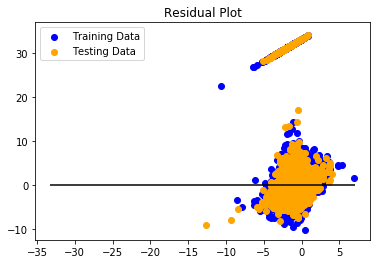

In [111]:
predictions = model.predict(X_test)
model.fit(X_train, y_train)
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")
plt.show()

In [113]:
# Used X_test_scaled, y_test_scaled, and model.predict(X_test_scaled) to calculate MSE and R2

### BEGIN SOLUTION
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test, predictions)
r2 = model.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 12.813839027537163, R2: 0.05161440585671173


In [114]:
# LASSO model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Lasso

### BEGIN SOLUTION
lasso = Lasso(alpha=.01).fit(X_train, y_train)

predictions = lasso.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = lasso.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 12.834935584226782, R2: 0.05005299475989178


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


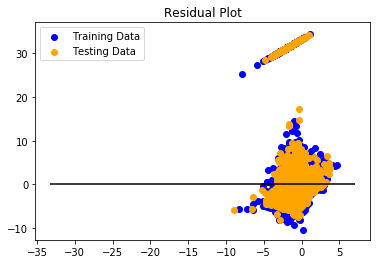

In [116]:
predictions = lasso.predict(X_test)
model.fit(X_train, y_train)
plt.scatter(lasso.predict(X_train), lasso.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(lasso.predict(X_test), lasso.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")
plt.show()

In [117]:
# Ridge model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Ridge

### BEGIN SOLUTION
ridge = Ridge(alpha=.01).fit(X_train, y_train)

predictions = ridge.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = ridge.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 12.813825771282684, R2: 0.051615386986625704


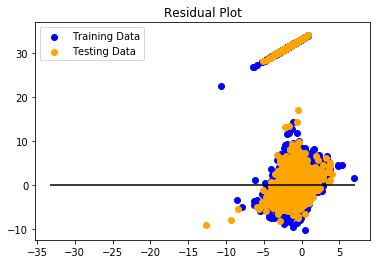

In [118]:
predictions = ridge.predict(X_test)
model.fit(X_train, y_train)
plt.scatter(ridge.predict(X_train), ridge.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(ridge.predict(X_test), ridge.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")
plt.show()

In [119]:
# ElasticNet model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import ElasticNet

### BEGIN SOLUTION
elasticnet = ElasticNet(alpha=.01).fit(X_train, y_train)

predictions = elasticnet.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = elasticnet.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 12.823524620903159, R2: 0.050897549870047694


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


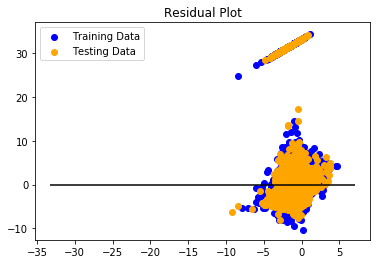

In [120]:
predictions = elasticnet.predict(X_test)
model.fit(X_train, y_train)
plt.scatter(elasticnet.predict(X_train), elasticnet.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(elasticnet.predict(X_test), elasticnet.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")
plt.show()

In [121]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor


In [124]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf = rf.fit(X_train, y_train)


In [125]:
predictions = rf.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = rf.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 12.611560690810682, R2: 0.06658555229818008


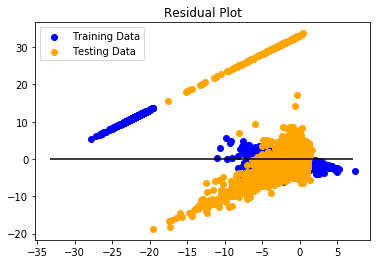

In [126]:
predictions = rf.predict(X_test)
model.fit(X_train, y_train)
plt.scatter(rf.predict(X_train), rf.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(rf.predict(X_test), rf.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")
plt.show()

In [179]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

ValueError: Found array with 0 sample(s) (shape=(0, 144)) while a minimum of 1 is required.

In [ ]:
predictions = model.predict(X_test)
model.fit(X_train, y_train)
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")
plt.show()

In [239]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

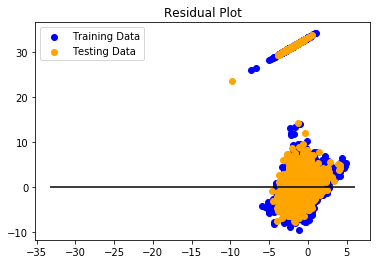

In [240]:
predictions = model.predict(X_test)
model.fit(X_train, y_train)
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")
plt.show()

In [241]:
# Used X_test_scaled, y_test_scaled, and model.predict(X_test_scaled) to calculate MSE and R2

### BEGIN SOLUTION
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test, predictions)
r2 = model.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 12.27135479755944, R2: 0.04993910935924684


In [34]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=.01).fit(X_train, y_train)

predictions = lasso.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = lasso.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 1.9305707531241627, R2: 0.06474834371046945


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [246]:
train.

<bound method NDFrame.describe of         Unnamed: 0  feature_1  feature_2  feature_3  elapsed_time  \
0                0          5          2          1           245   
1                1          4          1          0           396   
6                6          3          2          1           427   
9                9          2          2          0           549   
14              14          3          2          1           184   
16              16          2          2          0           580   
20              20          5          2          1           153   
23              23          2          2          0           123   
24              24          5          1          1           854   
26              26          2          3          0           215   
29              29          5          2          1           610   
30              30          3          1          1           153   
31              31          5          2          1           215   


In [257]:
# Ridge model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Ridge

### BEGIN SOLUTION
ridge = Ridge(alpha=.01).fit(X_train, y_train)

predictions = ridge.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = ridge.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 12.27133701868898, R2: 0.04994048581765608


In [13]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

In [133]:
train = pd.read_csv("pipelined_train.csv")
test = pd.read_csv("pipelined_test.csv")


train_binary = train.dropna()
bins = [-40,-20,40]

group_names = [1,0]
train_binary["target"] =  pd.cut(train_binary["target"], bins, labels=group_names)

y_binary = train_binary["target"]
X_binary = train_binary
del X_binary["target"]
del X_binary["card_id"]
del X_binary["first_active_month"]

from sklearn.model_selection import train_test_split

X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(X_binary, y_binary, random_state=42)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [134]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

classifier.fit(X_train_binary, y_train_binary)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [139]:
predictions = classifier.predict(X_test_binary)

MSE = mean_squared_error(y_test_binary, predictions)
r2 = classifier.score(X_test_binary, y_test_binary)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.010613353079106503, R2: 0.9893866469208935


Text(0.5,1,'2-class Precision-Recall curve: AP=0.03')

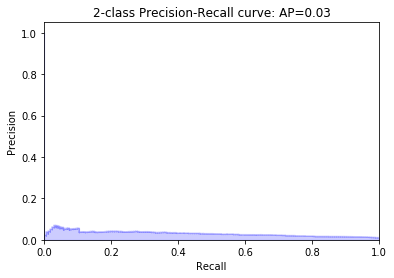

In [159]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

y_score = classifier.decision_function(X_test_binary)

average_precision = average_precision_score(y_test_binary, y_score)

precision, recall, _ = precision_recall_curve(y_test_binary, y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

Text(0.5,1,'2-class Precision-Recall curve: AP=0.02')

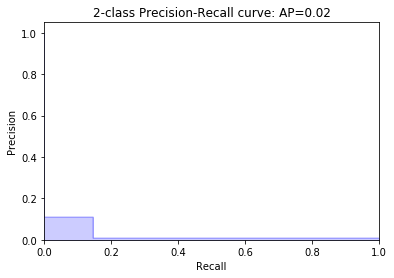

In [161]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train_binary, y_train_binary)

y_score = clf.predict(X_test_binary)

average_precision = average_precision_score(y_test_binary, y_score)


precision, recall, _ = precision_recall_curve(y_test_binary, y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

Text(0.5,1,'2-class Precision-Recall curve: AP=0.01')

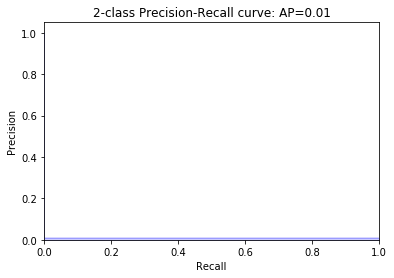

In [164]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train_binary, y_train_binary)

y_score = rf.predict(X_test_binary)

average_precision = average_precision_score(y_test_binary, y_score)

precision, recall, _ = precision_recall_curve(y_test_binary, y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))